# GE Stock Prediction
Here we are going to predict GE stock prices. Example from https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944

In [2]:
# Import Required Libraries
# Graph Functions
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,10) # Make the figures a bit bigger
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
import pandas as pd
import os

## Import and Inspect Data

In [6]:
display(os.getcwd())
df_ge = pd.read_csv('Users/mrm39/Desktop/AI/Homework/HW2/ge_stock.txt', engine='python')
df_ge.tail()

'C:\\Users\\mrm39\\Desktop\\AI\\Homework\\HW2'

FileNotFoundError: [Errno 2] No such file or directory: 'Users/mrm39/Desktop/AI/Homework/HW2/ge_stock.txt'

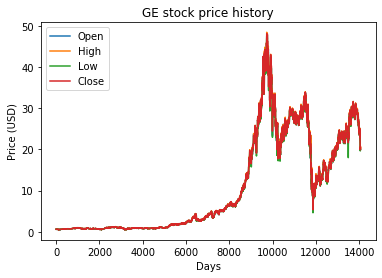

In [3]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(df_ge["Open"])
plt.plot(df_ge["High"])
plt.plot(df_ge["Low"])
plt.plot(df_ge["Close"])
plt.title('GE stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

## Preprocess the Data
We need to normalize the data in order to improve convergence time.

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

train_cols = ["Open","High","Low","Close","Volume"]
#train_cols = ["Open","High","Low","Volume"]
df_train, df_test = train_test_split(df_ge, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_train), len(df_test))
# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

# Train scalar only on Y
stock_min_max = MinMaxScaler()
stock_min_max.fit_transform(np.reshape(df_train.loc[:, "Close"].values, (-1, 1)))

Train and Test size 11246 2812


array([[0.00338425],
       [0.00338425],
       [0.00321827],
       ...,
       [0.56564471],
       [0.57270398],
       [0.57677987]])

## Reshape the Data for Training
Our current dataset is not in a form suitable for training.

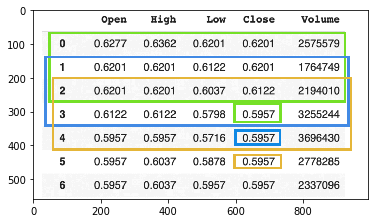

In [5]:
import matplotlib.image as mpimg
img = mpimg.imread('stock_training.png')
plt.imshow(img)

In [6]:
def build_timeseries(mat, y_col_index, TIME_STEPS):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y


def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat


In [7]:
TIME_STEPS = 3
BATCH_SIZE = 32
x_t, y_t = build_timeseries(x_train, 3, TIME_STEPS)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test, 3, TIME_STEPS)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

length of time-series i/o (11243, 3, 5) (11243,)
length of time-series i/o (2809, 3, 5) (2809,)


## Model Creation
Time to create our Keras Model

In [8]:
# Import functions from Keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb
lstm_model = Sequential()
lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, 
                                            x_t.shape[2]), 
                                            dropout=0.0, 
                                            recurrent_dropout=0.0))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(20,activation='relu'))
lstm_model.add(Dense(1,activation='linear'))
lstm_model.compile(loss='mean_squared_error', 
                   optimizer='sgd',
                   metrics=['mae'])

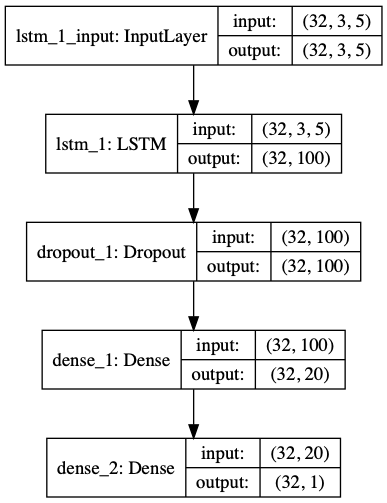

In [9]:
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils import model_to_dot
plot_model(lstm_model, show_shapes = True)

Train on 11232 samples, validate on 1376 samples
Epoch 1/50
11232/11232 [==============================] - 1s 99us/step - loss: 0.0329 - mae: 0.1319 - val_loss: 0.0159 - val_mae: 0.0987
Epoch 2/50
11232/11232 [==============================] - 1s 67us/step - loss: 0.0071 - mae: 0.0581 - val_loss: 0.0018 - val_mae: 0.0313
Epoch 3/50
11232/11232 [==============================] - 1s 67us/step - loss: 0.0028 - mae: 0.0289 - val_loss: 0.0010 - val_mae: 0.0222
Epoch 4/50
11232/11232 [==============================] - 1s 69us/step - loss: 0.0023 - mae: 0.0240 - val_loss: 0.0011 - val_mae: 0.0226
Epoch 5/50
11232/11232 [==============================] - 1s 66us/step - loss: 0.0020 - mae: 0.0221 - val_loss: 9.4468e-04 - val_mae: 0.0199
Epoch 6/50
11232/11232 [==============================] - 1s 67us/step - loss: 0.0020 - mae: 0.0220 - val_loss: 9.3624e-04 - val_mae: 0.0197
Epoch 7/50
11232/11232 [==============================] - 1s 71us/step - loss: 0.0018 - mae: 0.0214 - val_loss: 8.6643e-0

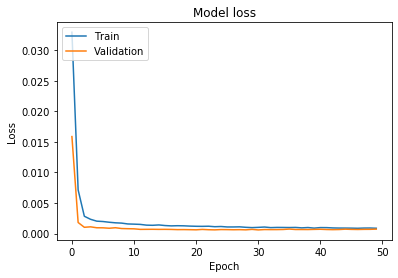

In [10]:
history = lstm_model.fit(x_t, y_t,
          batch_size=32, epochs=50, verbose=1,
          validation_data=(trim_dataset(x_val, BATCH_SIZE), 
                           trim_dataset(y_val, BATCH_SIZE)))

# Plot training & validation loss values
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


In [11]:
score = lstm_model.evaluate(x_t, y_t, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1] )

11232/11232 [==============================] - 0s 23us/step
Test score: 8.957336250387145e-05
Test accuracy: 0.007156509440392256


In [12]:
predicted = lstm_model.predict(trim_dataset(x_val, BATCH_SIZE))
display(predicted)

array([[0.57720196],
       [0.57702875],
       [0.5772981 ],
       ...,
       [0.329222  ],
       [0.32925388],
       [0.3287793 ]], dtype=float32)

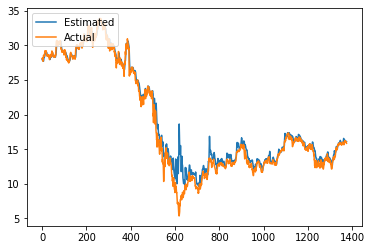

In [13]:
plt.figure()
plt.plot(stock_min_max.inverse_transform(predicted))
plt.plot(stock_min_max.inverse_transform(np.reshape(trim_dataset(y_val, BATCH_SIZE), (-1,1))))
plt.legend(['Estimated', 'Actual'], loc='upper left')

# Create Your Own Stock Prediction Algorithm
Follow similar steps to the above code, but for your own algorithm. Choose any stock and collect the data yourself. Please turn in a .txt or .csv file that contains the data.